In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.1'

In [4]:
from imutils import paths
IMG_PATH = 'new dataset'
images_path = list(paths.list_images(IMG_PATH))
import os
import cv2
import numpy as np

In [5]:
def load(path):
    data = []
    labels = []
    # loop over the input image
    for (i, imgpath) in enumerate(path):
        gray_img = cv2.imread(imgpath)
        image = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = np.array(image)
        label = imgpath.split(os.path.sep)[-2]
        data.append(image)
        labels.append(label)
    # return a tuple of data and label
    return data, labels

In [6]:
image_list, label_list = load(images_path)

In [7]:
image_list[0].shape

(224, 224, 3)

In [8]:
label_list_numerical = []
for i in label_list:
    if i == 'glioma':
        label_list_numerical.append(2)
    elif i == 'meningioma':
        label_list_numerical.append(1)
    elif i == 'pituitary':
        label_list_numerical.append(3)

In [9]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

In [10]:
label_list[0]

array([1, 0, 0])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test = train_test_split(
    image_list, 
    label_list,
    test_size = 0.1,
    random_state = 42)

In [12]:
print(len(X_train))
print(len(Y_train))

2757
2757


In [13]:
import tensorflow as tf
#process and batch the test data
test_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)

In [14]:
tf.config.run_functions_eagerly(True)

In [15]:
#process and batch the train data
train_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)

In [16]:
#Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_batch.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_batch.prefetch(buffer_size=AUTOTUNE)

In [17]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [19]:
#IMG_SHAPE = image_list[0].shape
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [20]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

In [23]:
prediction_layer.get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 3,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [24]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = img_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [27]:
initial_epochs = 20

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7839360782175310804
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17291156556624972406
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5480622700120758512
physical_device_desc: "device: XLA_GPU device"
]


In [29]:
history = model.fit(train_dataset, epochs=initial_epochs,validation_data=test_dataset)

Epoch 1/20
173/173 [==============================] - 695s 4s/step - loss: 1.0276 - accuracy: 0.5658 - val_loss: 0.8010 - val_accuracy: 0.6547
Epoch 2/20
173/173 [==============================] - 690s 4s/step - loss: 0.7837 - accuracy: 0.6707 - val_loss: 0.6580 - val_accuracy: 0.7459
Epoch 3/20
173/173 [==============================] - 691s 4s/step - loss: 0.6799 - accuracy: 0.7247 - val_loss: 0.6246 - val_accuracy: 0.7655
Epoch 4/20
173/173 [==============================] - 693s 4s/step - loss: 0.6140 - accuracy: 0.7508 - val_loss: 0.6192 - val_accuracy: 0.7752
Epoch 5/20
173/173 [==============================] - 699s 4s/step - loss: 0.5828 - accuracy: 0.7523 - val_loss: 0.5904 - val_accuracy: 0.7915
Epoch 6/20
173/173 [==============================] - 709s 4s/step - loss: 0.5297 - accuracy: 0.7824 - val_loss: 0.5738 - val_accuracy: 0.7948
Epoch 7/20
173/173 [==============================] - 710s 4s/step - loss: 0.5185 - accuracy: 0.7904 - val_loss: 0.5524 - val_accuracy: 0.8078

In [30]:
history

In [31]:
acc = history.history['accuracy']
print(acc)

[0.5658324360847473, 0.6706565022468567, 0.7247007489204407, 0.7508161067962646, 0.7522669434547424, 0.7823721170425415, 0.7903518080711365, 0.8066739439964294, 0.8041349053382874, 0.7979688048362732, 0.8186434507369995, 0.8142908811569214, 0.8208197355270386, 0.825534999370575, 0.8309757113456726, 0.8385926485061646, 0.825534999370575, 0.8320638537406921, 0.837504506111145, 0.8451215028762817]


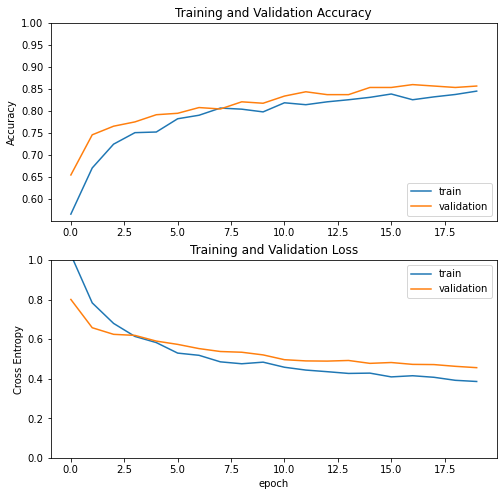

<Figure size 432x288 with 0 Axes>

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(history.history['val_accuracy'])
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(history.history['val_loss'])
#plt.plot(val_loss, label='Validation Loss')
plt.legend(['train', 'validation'],loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('accuracy-loss-efficientnet.png')

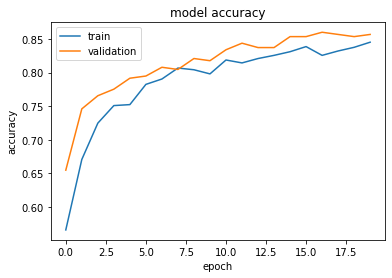

<Figure size 432x288 with 0 Axes>

In [37]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('accuracy_curve_efficient.png')

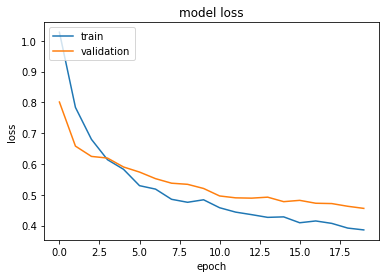

<Figure size 432x288 with 0 Axes>

In [38]:
#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('loss_curve_efficientnet.png')

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 17s 861ms/step - loss: 0.4559 - accuracy: 0.8567
Test accuracy : 0.8566775321960449


In [108]:
#test_dataset = test_batch.prefetch(buffer_size=AUTOTUNE)

In [40]:
loss

0.4559463858604431

In [38]:
#import tensorflow as tf

In [46]:
#model.save("model-efficientnet-image-size-224-with-augmentation.h5")

In [18]:
# load model
#model = load_model('model-efficient-net.h5')
# summarize model.
#model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [29]:
#from tensorflow.keras.models import load_model

In [31]:
# load model
#model = load_model('model-efficientnet-image-size-224-with-augmentation.h5')
# summarize model.
#model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [41]:
pred_prob = model.predict(test_dataset)

In [42]:
pred_prob

array([[5.69340825e-01, 4.01917517e-01, 2.87416726e-02],
       [3.51385176e-01, 6.48565054e-01, 4.97728433e-05],
       [8.63045081e-02, 7.16650426e-01, 1.97045147e-01],
       [3.52585502e-02, 7.18950391e-01, 2.45791003e-01],
       [3.67789790e-02, 8.32637012e-01, 1.30583957e-01],
       [9.57916498e-01, 6.73174765e-03, 3.53517495e-02],
       [3.45784385e-04, 2.37272098e-03, 9.97281432e-01],
       [1.15724273e-01, 8.36978495e-01, 4.72972691e-02],
       [7.36404479e-01, 1.63911586e-03, 2.61956364e-01],
       [1.33071944e-01, 8.64502668e-01, 2.42544198e-03],
       [2.59284556e-01, 7.11161673e-01, 2.95537077e-02],
       [3.03552486e-02, 1.71821844e-02, 9.52462554e-01],
       [9.02736902e-01, 1.17915617e-02, 8.54715332e-02],
       [3.43937567e-03, 9.95427608e-01, 1.13305484e-03],
       [8.37197527e-03, 4.42151800e-02, 9.47412789e-01],
       [4.07082734e-05, 1.02097716e-03, 9.98938262e-01],
       [2.99920142e-03, 1.34690320e-02, 9.83531713e-01],
       [1.88217510e-03, 8.46514

In [43]:
n_classes = 3

In [44]:
#Multiclass ROC curve
from scipy import interp
from sklearn.metrics import roc_auc_score

In [45]:
from sklearn.metrics import roc_curve, auc

In [46]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [47]:
roc_auc

{0: 0.963984674329502, 1: 0.881236571974218, 2: 0.9795991045991046}

In [48]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [49]:
roc_auc

{0: 0.963984674329502,
 1: 0.881236571974218,
 2: 0.9795991045991046,
 'micro': 0.9474371080860273}

In [50]:
#compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [51]:
roc_auc

{0: 0.963984674329502,
 1: 0.881236571974218,
 2: 0.9795991045991046,
 'micro': 0.9474371080860273,
 'macro': 0.9442874638226747}

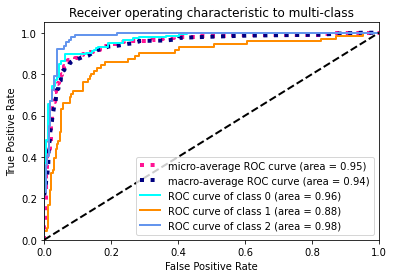

<Figure size 432x288 with 0 Axes>

In [52]:
from itertools import cycle
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc-efficientnet.png')

In [53]:
y_pred= np.argmax(pred_prob,axis=1)

In [54]:
y_pred

array([0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 2,
       2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2,
       1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 2, 1, 0, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0,
       1, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0,

In [55]:
y_test = np.argmax(Y_test, axis=1)

In [56]:
y_test 

array([0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 2,
       0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 0, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0,
       1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 0,
       2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0,
       0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0,
       1, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0,

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [58]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)

Accuracy: 0.856678


In [59]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred,average=None)
#print('Precision: %f' % precision)

In [60]:
precision

array([0.92198582, 0.76271186, 0.82242991])

In [61]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average = None)
#print('Recall: %f' % recall)

In [62]:
recall

array([0.89655172, 0.63380282, 0.96703297])

In [63]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average = None)
#print('F1 score: %f' % f1)

In [64]:
f1

array([0.90909091, 0.69230769, 0.88888889])

In [65]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[130  11   4]
 [ 11  45  15]
 [  0   3  88]]


In [48]:
#import pickle

In [49]:
# save:
#f = open('history-efficientnet-image-size-224-with-augmentation.pckl', 'wb')
#pickle.dump(history.history, f)
#f.close()

In [43]:
# retrieve:    
#f = open('history.pckl', 'rb')
#history2 = pickle.load(f)
#f.close()

In [44]:
#history == history2

False

In [45]:
#history.history == history2

True

In [46]:
#history2['accuracy']

[0.45955750346183777,
 0.6238664984703064,
 0.6851650476455688,
 0.7319550514221191,
 0.7461008429527283,
 0.7627856135368347,
 0.7733043432235718,
 0.7947043776512146,
 0.8012332320213318,
 0.807399332523346,
 0.8113892078399658,
 0.815741777420044,
 0.8258976936340332,
 0.8233587145805359,
 0.8251723051071167,
 0.8371418118476868,
 0.8338773846626282,
 0.8349655270576477,
 0.8487486243247986,
 0.8472977876663208]